CatBoost Model

In [2]:
!pip install catboost



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Categorical columns used: ['Sex', 'Embarked', 'Title', 'TicketPrefix', 'CabinDeck', 'AgeBand', 'FareBand', 'Sex_Pclass', 'Sex_AgeBand', 'Embarked_Pclass', 'Title_AgeBand', 'Pclass_FareBand']
Best iteration: 1
Validation AUC: 0.8953667953667954


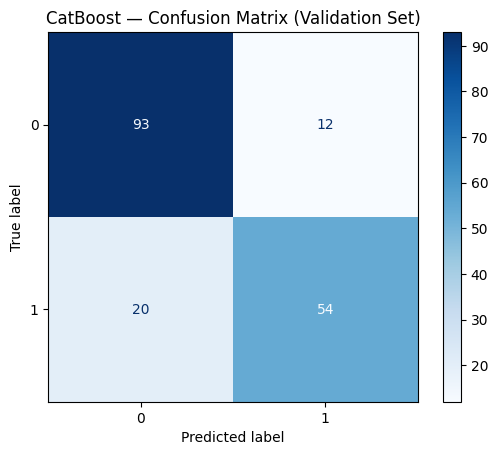

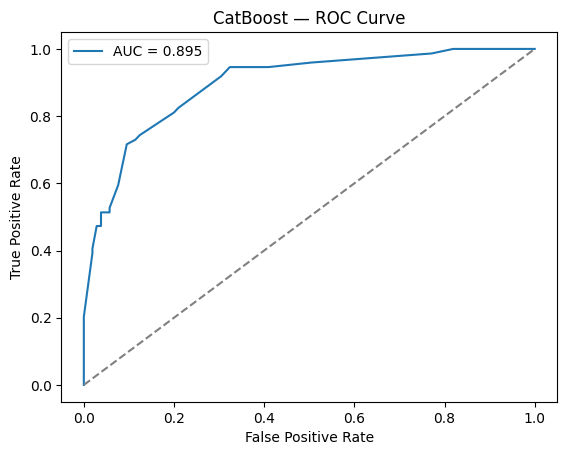

Ready for Kaggle: ../submissions/submission_catboost.csv


In [3]:
# ============================================================
# CatBoost Model Using Engineered Features (All Cat Columns)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
import json
import numpy as np
from catboost import CatBoostClassifier, Pool

# ============================================================
# 1. Load processed datasets
# ============================================================

train = pd.read_csv("../data/processed_v2/train_features.csv")
test = pd.read_csv("../data/processed_v2/test_features.csv")

y = train["Survived"]
X = train.drop(columns=["Survived", "PassengerId"])
X_test_final = test.drop(columns=["PassengerId"])
test_passenger_ids = test["PassengerId"]

# ============================================================
# 2. Load categorical metadata
# ============================================================

with open("../data/processed_v2/processed_metadata.json", "r") as f:
    meta = json.load(f)

categorical_cols = list(meta.keys())
print("Categorical columns used:", categorical_cols)

# Convert categorical columns to string (CatBoost requirement)
for col in categorical_cols:
    X[col] = X[col].astype(str)
    X_test_final[col] = X_test_final[col].astype(str)

# Identify categorical column indices
cat_indices = [X.columns.get_loc(col) for col in categorical_cols]

# ============================================================
# 3. Train-validation split
# ============================================================

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_pool = Pool(X_train, y_train, cat_features=cat_indices)
val_pool = Pool(X_val, y_val, cat_features=cat_indices)

# ============================================================
# 4. Build CatBoost model
# ============================================================

model = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    od_type="Iter",
    od_wait=40,           # early stopping patience
    verbose=False
)

model.fit(train_pool, eval_set=val_pool)

print("Best iteration:", model.get_best_iteration())

# ============================================================
# 5. Validation predictions
# ============================================================

y_proba = model.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_proba)
print("Validation AUC:", auc)

# ============================================================
# 6. Confusion Matrix
# ============================================================

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("CatBoost — Confusion Matrix (Validation Set)")
plt.show()

# ============================================================
# 7. ROC Curve
# ============================================================

fpr, tpr, _ = roc_curve(y_val, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CatBoost — ROC Curve")
plt.legend()
plt.show()

# ============================================================
# 8. Train on full dataset
# ============================================================

full_pool = Pool(X, y, cat_features=cat_indices)

final_model = CatBoostClassifier(
    iterations=model.get_best_iteration(),
    learning_rate=0.03,
    depth=6,
    loss_function="Logloss",
    random_seed=42,
    verbose=False
)

final_model.fit(full_pool)

# ============================================================
# 9. Predict on test set
# ============================================================

test_proba = final_model.predict_proba(X_test_final)[:, 1]
test_predictions = (test_proba >= 0.5).astype(int)

submission = pd.DataFrame({
    "PassengerId": test_passenger_ids,
    "Survived": test_predictions
})

output_path = "../submissions/submission_catboost.csv"
submission.to_csv(output_path, index=False)

print("Ready for Kaggle:", output_path)